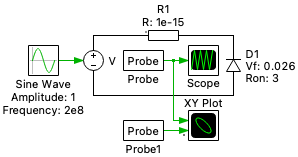

#### A simple, nonlinear circuit model
Originally implemented in PLECS. A resistor and a diode excited with a time harmonic signal (200 MHz).
This model determines the current drawn from the voltage source.

The goal is to use automatic differentiation to calculate $\partial i/\partial v$ which is needed
for the nonlinear Finite Element Method.

In [1]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

In [2]:
mutable struct ElectricDevice{D, T}
    ti :: Int
    it :: Int
    D0 :: Matrix{T}
    D1 :: Matrix{T}
    xp :: Vector{T}
    up :: Vector{T}
    x  :: Vector{T}
    u  :: Vector{T}
    y  :: Vector{T}
end

function ElectricDevice{D, T}(D0, D1) where {D, T}
    N, M = size(D0[:,:])
    device = ElectricDevice{D, T}(
        0, 0, zeros(T, N, M), zeros(T, N, M),
        zeros(T, N), zeros(T, M),
        zeros(T, N), zeros(T, M), zeros(T, M)
    )
    device.D0 .= D0
    device.D1 .= D1
    return device
end

function natPreComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function forcedComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function natPostComm(state)
    u = state.u
    if state.ti == 1 return (u[1]  < -u[2]) ? 2 : 1 end
    if state.ti == 2 return (u[1]  >=-u[2]) ? 1 : 2 end
end

function update!(state)    
    if state.ti == 1 D = state.D0 end
    if state.ti == 2 D = state.D1 end
    state.y[:] .= D * state.u
end

function init!(state)
    state.ti = 1
    state.it = 0
end

function step!(state, excitation)
    state.u[1] = excitation
    state.u[2] = 0.026
    state.ti = natPreComm(state)
    state.ti = natPostComm(state)
    state.ti = forcedComm(state)
    update!(state)
    state.up .= state.u
end

step! (generic function with 1 method)

In [3]:
D0 = [ 0.0 0.0
      -1.0 0.0]
D1 = [-0.333333333333333204 -0.333333333333333204
      -0.999999999999999667  3.33333333333333261e-16]

d = ElectricDevice{:D, Dual{Float64}}(D0, D1)
init!(d)

t = range(0, 5e-9, step=0.01e-9)
u = zeros(length(t), 2)
y = zeros(length(t), 2)
dydu = zeros(length(t))

for i=1:length(t)
    step!(d, sin(2π * 2e8 * t[i]) .+ ε)
    u[i, :] .= value.(d.u)
    y[i, :] .= value.(d.y)
    dydu[i]  = partials(d.y[1])
end

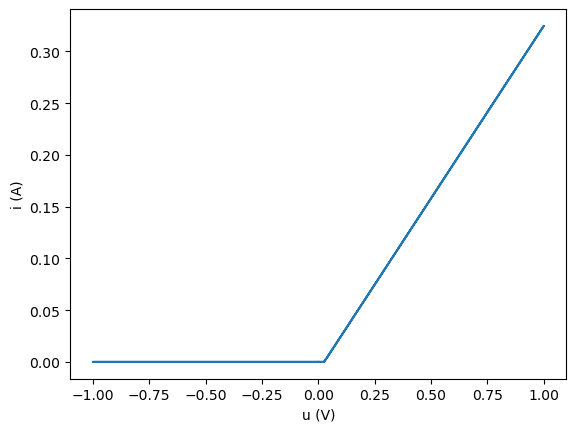

In [4]:
using PyPlot
plot(-u[:, 1], y[:, 1])
xlabel("u (V)")
ylabel("i (A)")
nothing

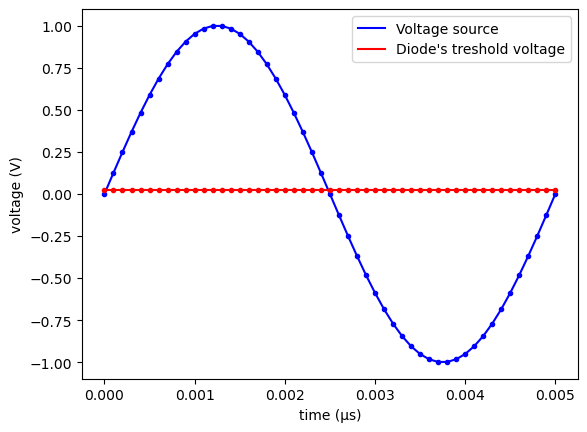

In [5]:
using DelimitedFiles
c = readdlm("out.csv", '\t') # gcc diode.c && ./a.out > out.csv

plot(1e6t[1:10:end], c[1:10:end, 1], "b-")
plot(1e6t[1:10:end], c[1:10:end, 2], "r-")
plot(1e6t[1:10:end], u[1:10:end, 1], "b.")
plot(1e6t[1:10:end], u[1:10:end, 2], "r.")
xlabel("time (μs)")
ylabel("voltage (V)")
legend(("Voltage source", "Diode's treshold voltage"));

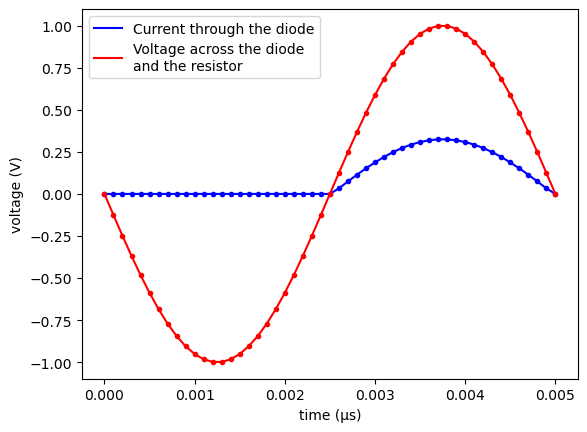

In [6]:
plot(1e6t[1:10:end], c[1:10:end, 3], "b-")
plot(1e6t[1:10:end], c[1:10:end, 4], "r-")
plot(1e6t[1:10:end], y[1:10:end, 1], "b.")
plot(1e6t[1:10:end], y[1:10:end, 2], "r.")
xlabel("time (μs)")
ylabel("voltage (V)")
legend(("Current through the diode", "Voltage across the diode\nand the resistor"));

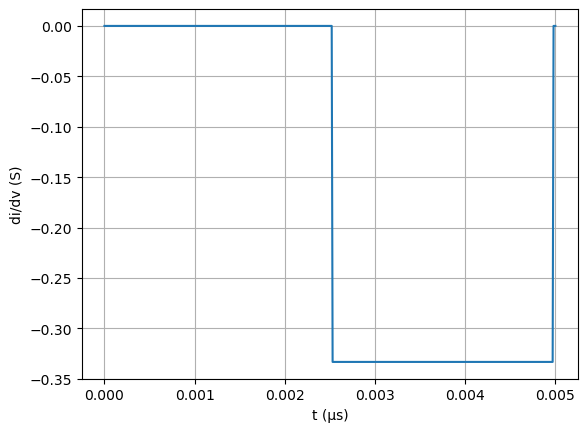

In [7]:
plot(1e6t, dydu)
xlabel("t (μs)")
ylabel("di/dv (S)")
grid();

In [8]:
using ACME

cir = @circuit begin
    v  = voltagesource(), [-] == gnd
    i  = currentprobe(),  [-] == gnd
    r1 = resistor(3.0),   [1] == v[+]
    d1 = diode(is=1e-6),  [-] == r1[2], [+] == i[+]
end
nothing

In [9]:
Δt = 0.01e-9
model = DiscreteModel(cir, Δt)
u = [1.0sin(2π * 2e8 * ti) for ti in t]
y = run!(model, [ui for c in 1:1, ui in u])

1×501 Matrix{Float64}:
 0.0  3.95041e-7  6.34002e-7  …  -1.7319e-6  -6.52953e-7  -9.796e-21

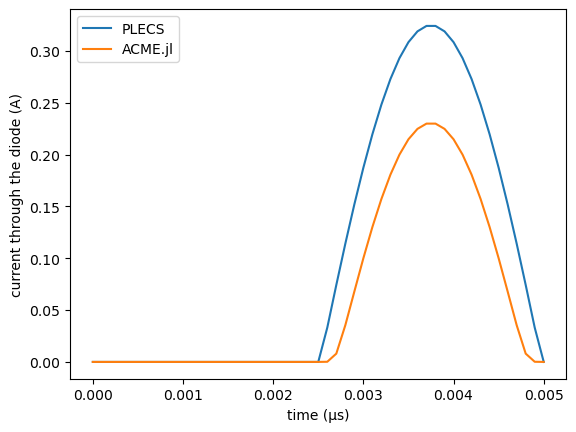

In [10]:
plot(1e6t[1:10:end], c[1:10:end, 3])
plot(1e6t[1:10:end],-y[1:10:end])
xlabel("time (μs)")
ylabel("current through the diode (A)")
legend(("PLECS", "ACME.jl"));

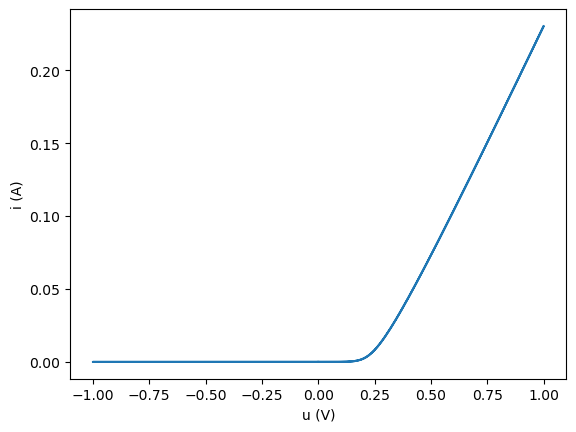

In [11]:
using PyPlot
plot(-u[:], -y[:])
xlabel("u (V)")
ylabel("i (A)")
nothing